In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# BCE classifier

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict

import torch.nn as nn
from torch import optim
import torch
from torch import Tensor
from torch import autograd

In [ ]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,1),  nn.Sigmoid())
init_net(net)

In [ ]:
model = ModelWrapper(net)

data, test = get_paper_data(200000, bm=0, bs=32, n_test=1000000)

In [ ]:
model.fit(200, data=data, opt=partialler(optim.Adam,lr=1e-4), loss=nn.BCELoss(),
          cbs=[LossTracker(),SaveBest('weights/best_bce.h5'),EarlyStopping(5)])

1: Train=0.3642620343053341 Valid=0.3394755549144745
2: Train=0.33858933008790015 Valid=0.3357032646608353
3: Train=0.3375037435722351 Valid=0.33683658094406127
4: Train=0.3365854949569702 Valid=0.33602648341655733
5: Train=0.33595397209286687 Valid=0.33244678608894346
6: Train=0.33528966082334516 Valid=0.3328556462335587
7: Train=0.3349935372161865 Valid=0.33193717790126803
8: Train=0.3348166132616997 Valid=0.33204128554344176
9: Train=0.33459743103981016 Valid=0.3318776100254059
10: Train=0.3344771250808239 Valid=0.3315365777492523
11: Train=0.33438269484877586 Valid=0.3322515998315811
12: Train=0.3341586202394962 Valid=0.3314780873632431
13: Train=0.33409448876976966 Valid=0.3318070869779587
14: Train=0.3340829892754555 Valid=0.33160997895240785
15: Train=0.3341433835732937 Valid=0.3323286833286285
16: Train=0.3338707925093174 Valid=0.33168937611103055
17: Train=0.33385268069028856 Valid=0.3316899949264526
Early stopping
Loading best model


In [ ]:
model.save('weights/BCE_Test.h5')

model.load('weights/BCE_Test.h5')

## BM 0

In [ ]:
preds = model.predict(test)

In [ ]:
preds

array([[9.0480447e-01],
       [8.8153815e-01],
       [8.3327186e-01],
       ...,
       [8.5494584e-01],
       [8.7123271e-03],
       [8.1036997e-04]], dtype=float32)

In [ ]:
df = pd.DataFrame({'pred':preds.squeeze()})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,0.904804,1.0
1,0.881538,1.0
2,0.833272,1.0
3,0.929002,1.0
4,0.870255,1.0


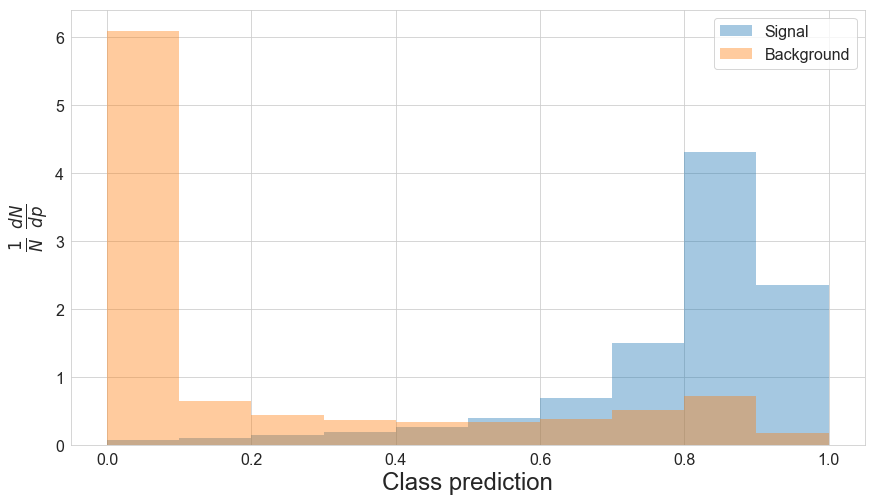

In [ ]:
plot_preds(df)

In [ ]:
bin_preds(df, np.linspace(0,1,11))

In [ ]:
df.head()

,pred,gen_target,pred_bin
0,0.904804,1.0,9
1,0.881538,1.0,8
2,0.833272,1.0,8
3,0.929002,1.0,9
4,0.870255,1.0,8


In [ ]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [ ]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.))

In [ ]:
f_s, f_b

(tensor([1.6624e-02, 1.3828e-02, 1.8924e-02, 2.6608e-02, 3.9102e-02, 6.8506e-02,
         1.4986e-01, 4.3065e-01, 2.3590e-01, 2.0000e-13]),
 tensor([6.7425e-01, 4.3754e-02, 3.5896e-02, 3.3292e-02, 3.3916e-02, 3.7870e-02,
         5.0556e-02, 7.2550e-02, 1.7920e-02, 2.0000e-13]))

In [ ]:
asimov = (50*f_s)+(1000*f_b)

In [ ]:
asimov, asimov.sum()

(tensor([6.7508e+02, 4.4445e+01, 3.6842e+01, 3.4622e+01, 3.5871e+01, 4.1295e+01,
         5.8049e+01, 9.4082e+01, 2.9715e+01, 2.1000e-10]), tensor(1050.))

In [ ]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([28.92131805, 28.76420593, 28.61306763, 28.46774292, 28.32924652,
       28.19685364, 28.07051849, 27.95019531, 27.83582306, 27.72717285,
       27.62439728, 27.52715302, 27.43580627, 27.3497467 , 27.26907349,
       27.19387817, 27.12342072, 27.05917358, 26.99913788, 26.94515228,
       26.89550781, 26.85111237, 26.81206512, 26.77698517, 26.74707031,
       26.72200775, 26.70154572, 26.68579865, 26.67455292, 26.66786194,
       26.66566467, 26.66783905, 26.6743927 , 26.68484497, 26.70071411,
       26.72014618, 26.74320984, 26.77143097, 26.80275726, 26.83906555,
       26.87847137, 26.92232513, 26.97077179, 27.02194977, 27.07741547,
       27.1366806 , 27.1996994 , 27.26648712, 27.33695221, 27.41109467,
       27.48871613, 27.57009888, 27.65488434, 27.74324036, 27.83505249,
       27.93063354, 28.0293045 , 28.13136292, 28.23678589, 28.34550476,
       28.45751953])

In [ ]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [ ]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

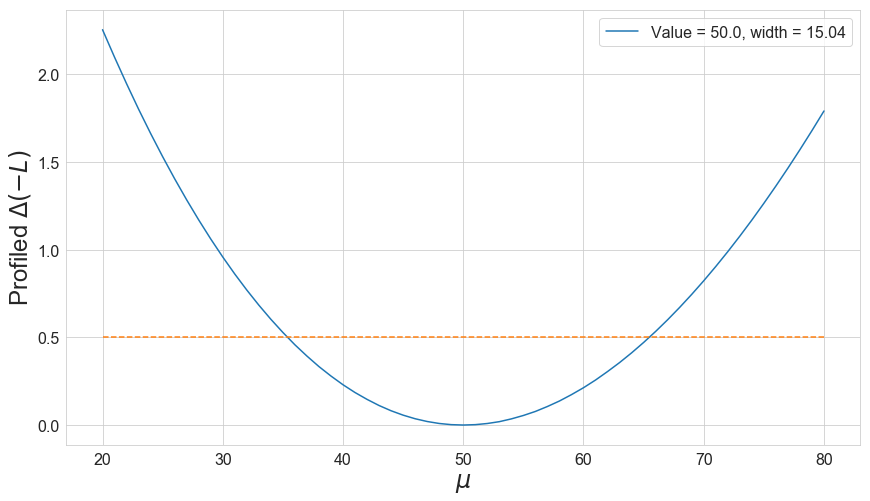

In [ ]:
plot_likelihood(y-y.min())

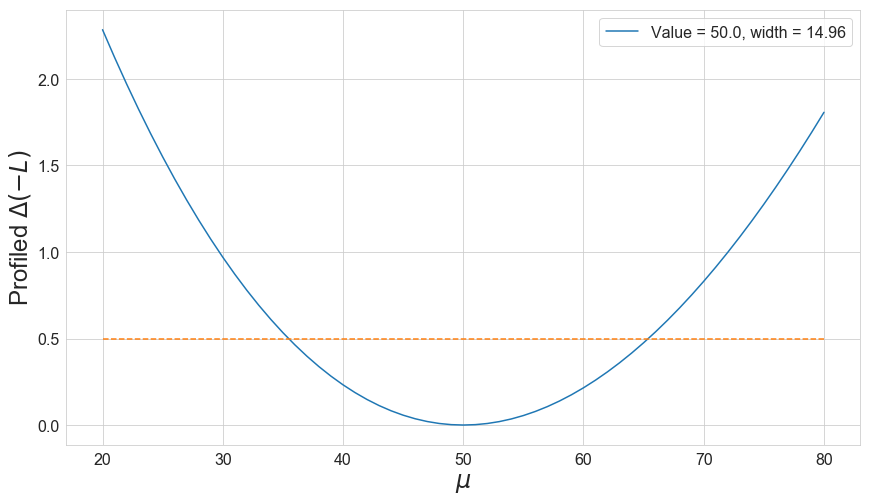

In [ ]:
plot_likelihood(y_tf2-y_tf2.min())

# Nuisances - via interpolation

In [ ]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [ ]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, bins=np.linspace(0,1,11))

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [ ]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,0.904804,1.0,9,0.904804,9,0.904804,9,0.904804,9,0.904804,9,0.904804,9
1,0.881538,1.0,8,0.881538,8,0.881538,8,0.881538,8,0.881538,8,0.881538,8
2,0.833272,1.0,8,0.833272,8,0.833272,8,0.833272,8,0.833272,8,0.833272,8
3,0.929002,1.0,9,0.929002,9,0.929002,9,0.929002,9,0.929002,9,0.929002,9
4,0.870255,1.0,8,0.870255,8,0.870255,8,0.870255,8,0.870255,8,0.870255,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0.313521,0.0,3,0.422260,4,0.313521,3,0.215886,2,0.275279,2,0.340608,3
999996,0.001504,0.0,0,0.002515,0,0.001504,0,0.000902,0,0.001486,0,0.001523,0
999997,0.854946,0.0,8,0.867466,8,0.854946,8,0.831615,8,0.836559,8,0.875299,8
999998,0.008712,0.0,0,0.011237,0,0.008712,0,0.007096,0,0.007835,0,0.009840,0


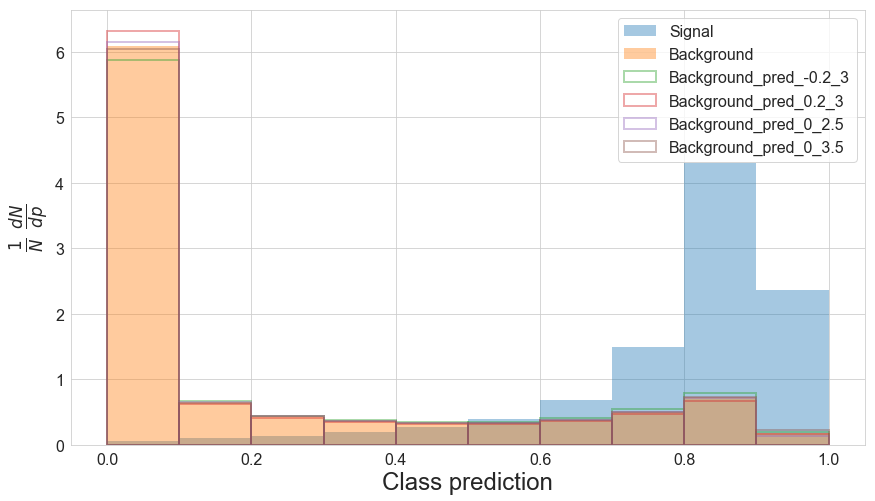

In [ ]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'])

In [ ]:
b_shapes['f_b_nom']

tensor([6.7425e-01, 4.3754e-02, 3.5896e-02, 3.3292e-02, 3.3916e-02, 3.7870e-02,
        5.0556e-02, 7.2550e-02, 1.7920e-02, 2.0000e-13])

In [ ]:
b_shapes['f_b_up']

tensor([[6.9533e-01, 4.1668e-02, 3.4260e-02, 3.1918e-02, 3.1748e-02, 3.5928e-02,
         4.6406e-02, 6.6362e-02, 1.6380e-02, 2.0000e-13],
        [6.6927e-01, 4.3578e-02, 3.5850e-02, 3.3242e-02, 3.3862e-02, 3.8096e-02,
         5.0444e-02, 7.2702e-02, 2.2952e-02, 2.0000e-13]])

In [ ]:
b_shapes['f_b_dw']

tensor([[6.5406e-01, 4.4722e-02, 3.7742e-02, 3.5076e-02, 3.5334e-02, 4.0788e-02,
         5.4066e-02, 7.8604e-02, 1.9606e-02, 2.0000e-13],
        [6.7920e-01, 4.3948e-02, 3.5838e-02, 3.3368e-02, 3.3914e-02, 3.8020e-02,
         5.0506e-02, 7.1882e-02, 1.3320e-02, 2.0000e-13]])

In [ ]:
f_s

tensor([1.6624e-02, 1.3828e-02, 1.8924e-02, 2.6608e-02, 3.9102e-02, 6.8506e-02,
        1.4986e-01, 4.3065e-01, 2.3590e-01, 2.0000e-13])

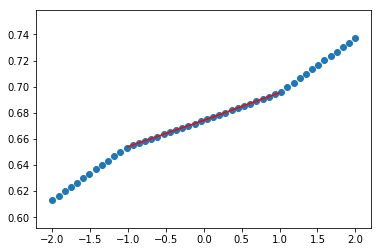

In [ ]:
i = 0
d = b_shapes['f_b_dw'][0][i]
n = b_shapes['f_b_nom'][i]
u = b_shapes['f_b_up'][0][i]
interp = []
rs = np.linspace(-2,2)
for r in rs: interp.append(interp_shape(Tensor((r,0))[None,:], **b_shapes)[0][i].data.item())
plt.scatter(rs, interp)
plt.plot([-1,0,1],[d,n,u], label=i, color='r')

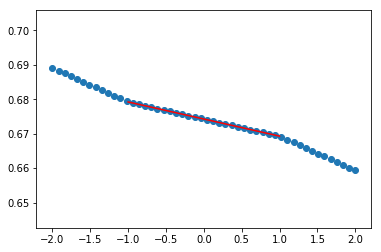

In [ ]:
i = 0
d = b_shapes['f_b_dw'][1][i]
n = b_shapes['f_b_nom'][i]
u = b_shapes['f_b_up'][1][i]
interp = []
ls = np.linspace(-2,2)
for l in ls: interp.append(interp_shape(Tensor((0,l))[None,:], **b_shapes)[0][i].data.item())
plt.scatter(ls, interp)
plt.plot([-1,0,1],[d,n,u], label=i, color='r')

In [ ]:
b_shapes['f_b_nom']

tensor([6.7425e-01, 4.3754e-02, 3.5896e-02, 3.3292e-02, 3.3916e-02, 3.7870e-02,
        5.0556e-02, 7.2550e-02, 1.7920e-02, 2.0000e-13])

In [ ]:
alpha = Tensor((1,0))[None,:]
interp_shape(alpha, **b_shapes).squeeze()

tensor([6.9533e-01, 4.1668e-02, 3.4260e-02, 3.1918e-02, 3.1748e-02, 3.5928e-02,
        4.6406e-02, 6.6362e-02, 1.6380e-02, 2.0000e-13])

In [ ]:
b_shapes['f_b_up']

tensor([[6.9533e-01, 4.1668e-02, 3.4260e-02, 3.1918e-02, 3.1748e-02, 3.5928e-02,
         4.6406e-02, 6.6362e-02, 1.6380e-02, 2.0000e-13],
        [6.6927e-01, 4.3578e-02, 3.5850e-02, 3.3242e-02, 3.3862e-02, 3.8096e-02,
         5.0444e-02, 7.2702e-02, 2.2952e-02, 2.0000e-13]])

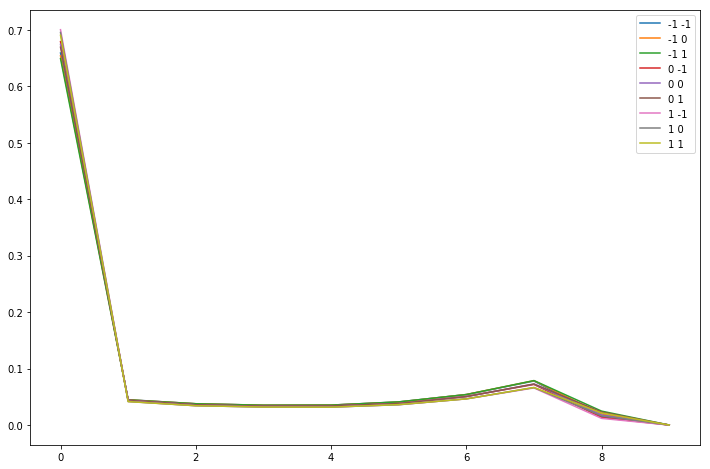

In [ ]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [ ]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [ ]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [ ]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [ ]:
nll = to_np(nll)

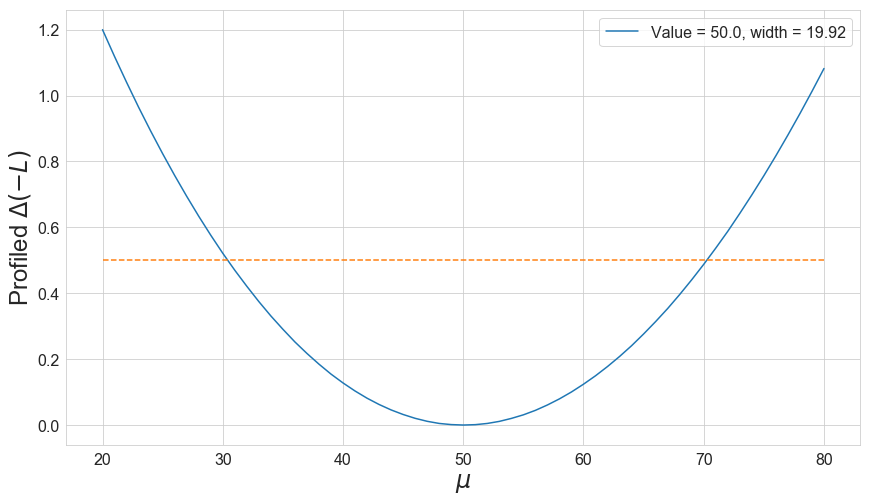

In [ ]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [ ]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

In [ ]:
nll = to_np(nll)

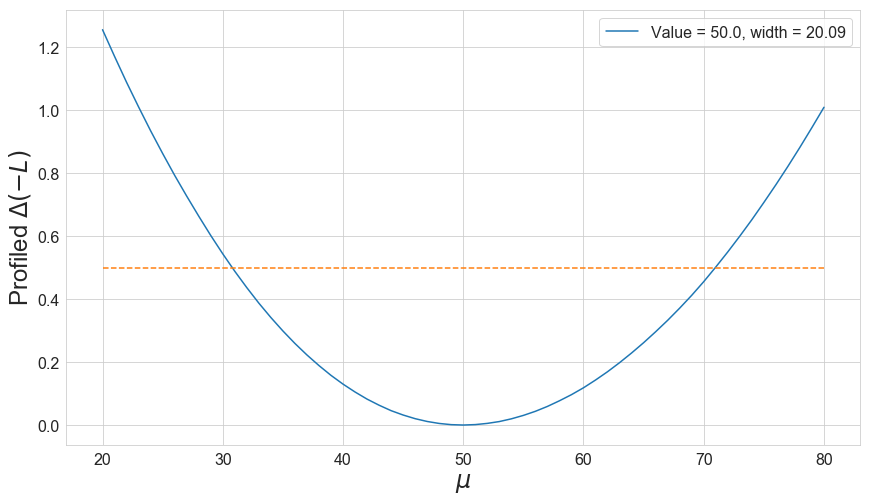

In [ ]:
plot_likelihood(nll-nll.min())

## BM 2

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

In [ ]:
nll = to_np(nll)

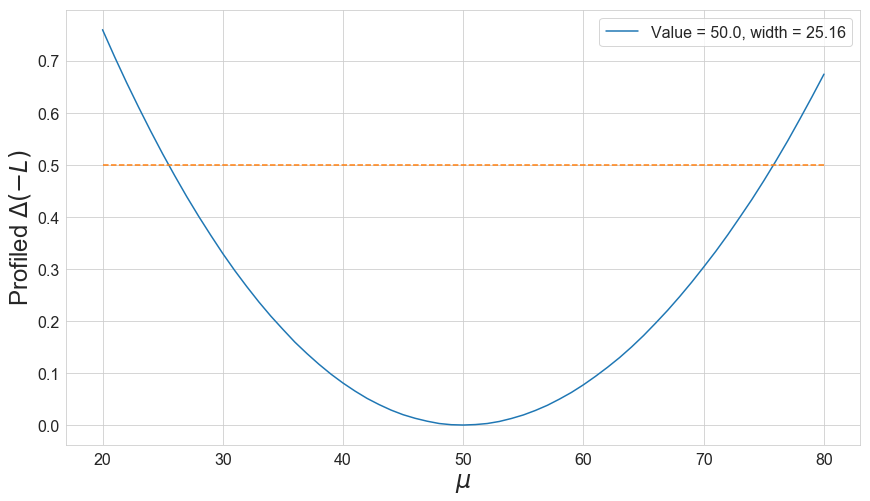

In [ ]:
plot_likelihood(nll-nll.min())